In [1]:
%run config.ipynb
import nltk
from nltk.corpus import stopwords
import spacy
import re

import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model, clone_model

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read Datasets

In [2]:
# business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
# check_in = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
# tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
# user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

In [3]:
review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,text_after_cleaning
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,0,0,0,This is an amazing indian Bistro!!I If I do sa...,2014-07-18 21:18:03,amazing indian bistroi say myself never indian...
1,40I7k47AhStBAT-jYEYAAw,in0ZczXTwyRZXJzAgsYVBQ,VyVIneSU7XAWgMBllI6LnQ,5,0,0,0,The food was amazing and the waitress was supe...,2017-12-04 03:18:35,food amazing waitress super nice would definit...
2,FdQYfgrRtmi_36S3cwVO5Q,e99DAYuwAwXoaDAJTO0NDg,_yIvVucQh5W84m3Pk4dndg,3,0,0,0,We tried to go to sweet tooth but the line was...,2016-10-04 15:42:25,tried go sweet tooth line door opted try place...
3,GSNn8QyqVytg-5CFOeL_MA,jed_BPMeFS06VPcd99VLwg,vA7BBQ9ro0fiKXE8tLF7zA,1,1,0,0,"If I had to rate just the beer, I'd rate highe...",2011-05-06 22:01:39,rate beer rate higher 1 stars make long story...
4,wvpDEl6RUygLqnCazTcNYg,XK9riyKgdf_v7uPc4fbrDQ,QDRFdG8gPPKL7r4yic8j7Q,4,1,0,0,Tried this place for the first time in August ...,2017-08-07 00:42:46,tried place first time got burritos 2 soft ta...
...,...,...,...,...,...,...,...,...,...,...
401051,XUikQYju8aeeK0Pl_SMl-A,Jt1zgNmwz_jheOSmEsljPQ,2PZRu5q70e0p7jEMxaXsDw,4,1,0,1,"As per my usual tradition, I went to Bier Mark...",2012-02-25 22:22:29,per usual tradition went annual fondue festiva...
401052,EZ97THwgKAV5RklorwVbDg,taFjXgrhUJpTYbzsOET-nA,cfQfc3q9_RPgx-eKtHQtCQ,5,2,0,0,"Awesome, quick service. Staff was polite and h...",2014-01-09 20:21:09,awesome quick service staff polite out even ro...
401053,RsnNPnZwTQRrwdCHAxp3kQ,KW-fOrjuJBJbyPfhlEtXBw,zjwdU1OdlbKTGjm-IfD4TQ,5,0,0,0,Had dinner at the Essen Haus a few weeks ago w...,2012-02-08 03:08:23,dinner haus bunch friends going haus since op...
401054,qn6P0SaBAJkv26WnWLpt4g,Pub1A9LA1NSg7jNJjbUPJA,narFmQxq5-D2eHZf4q0hgA,4,0,1,0,Been donating for YEARS and the only reason I ...,2016-05-02 22:40:04,donating reason give 5 stars starting get chea...


## Preprocessing

In [4]:
X = review["text"]

In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
stop_words = set(stopwords.words('english')) 

In [6]:
# This process will a long time to run, so make sure you create a copy yourself after finish
SYMBOL_RE = re.compile('[/(){}\[\]\|@,.:!?;\-*]')
WEBSITES_RE = re.compile('http[s]?[:]?[.]?[\/]+[^.\/]+([.][^.\/\s]+)+[^\s]*')
ABBR_RE = re.compile('[a-z]*[\'][^ ]*')
def clean_text(text):
    ents = [word.text for word in nlp(text).ents if word.label_ in ['PERSON', "ORG", "GPE", "DATE", "TIME"]]
    for ent in ents:
        text = text.replace(ent, '')
    text = text.lower()
    text = WEBSITES_RE.sub('', text)

    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = SYMBOL_RE.sub('', text)
    text = ABBR_RE.sub('', text)
    return text

In [17]:
# run the commented line if you want to reproduce the X
# X = X.apply(clean_text)
X = review["text_after_cleaning"].astype('str')

## Split Dataset

In [18]:
y = review["stars"]
y = y.apply(lambda x : x - 1) # convert range(1,7) to range(0,6) for more precise when adding dense layer
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Word Embedding

In [19]:
MAX_VOCAB_SIZE = 50000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [20]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 164214 unique tokens.


In [21]:
X_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', X_train.shape)

T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

Shape of data train tensor: (268707, 493)
Shape of data test tensor: (132349, 493)


## Modelling

In [22]:
def fit_model(model, epochs=3, batch_size=128, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    r = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    plot(r)
    return model, r

def plot(r):
    plt.xlabel('# epochs')
    length = len(r.history[next(iter(r.history))])
    plt.xticks(np.arange(length), np.arange(1, length+1))
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.plot(r.history['accuracy'], label='acc')
    plt.plot(r.history['val_accuracy'], 'm', label='val_acc')
    plt.legend()

def create_model():
    D = 150
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    i = Input(shape=(T,))
    x = Embedding(num_words, D)(i)
#     x = Bidirectional(LSTM(D//2, return_sequences=True))(x)
    x = LSTM(D, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(5, activation='softmax')(x)
    model = Model(i, x)
    model.summary(120)
    return model

Model: "functional_1"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 493)]                                   0                 
________________________________________________________________________________________________________________________
embedding (Embedding)                                 (None, 493, 150)                                7500000           
________________________________________________________________________________________________________________________
lstm (LSTM)                                           (None, 493, 150)                                180600            
________________________________________________________________________________________________________________________
global_max

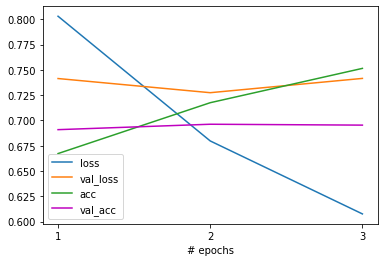

In [23]:
m, r = fit_model(create_model())

Model: "functional_9"
__________________________________________________________________________________________________________________________________
Layer (type)                                              Output Shape                                        Param #             
input_6 (InputLayer)                                      [(None, 495)]                                       0                   
__________________________________________________________________________________________________________________________________
embedding_5 (Embedding)                                   (None, 495, 50)                                     1500000             
__________________________________________________________________________________________________________________________________
lstm_5 (LSTM)                                             (None, 495, 100)                                    60400               
_____________________________________________________________

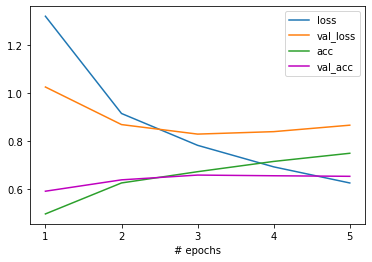

In [33]:
m1, r1 = fit_model(create_model())

Model: "functional_13"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_8 (InputLayer)                                  [(None, 495)]                                   0                 
________________________________________________________________________________________________________________________
embedding_7 (Embedding)                               (None, 495, 100)                                3000000           
________________________________________________________________________________________________________________________
bidirectional_6 (Bidirectional)                       (None, 495, 100)                                60400             
________________________________________________________________________________________________________________________
global_ma

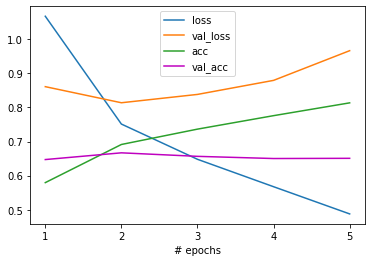

In [39]:
m2, r2 = fit_model(create_model())